In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.multitest import multipletests
import latex

In [2]:
data = pd.read_excel('S1File.xlsx', sheet_name = 'CFS_JPT_Seroarray')
data = data.iloc[1254:1272]

In [3]:
infections = pd.read_csv('epi_data_age_gender.csv').iloc[50:]
infections.Infection = infections.Infection.apply(lambda x: x == 'Yes')
inf = list(infections[infections.Infection == True].ID)
uninf = list(infections[infections.Infection == False].ID)

In [4]:
print(inf)

['CFS_02', 'CFS_03', 'CFS_04', 'CFS_06', 'CFS_07', 'CFS_08', 'CFS_09', 'CFS_10', 'CFS_11', 'CFS_12', 'CFS_13', 'CFS_14', 'CFS_16', 'CFS_17', 'CFS_18', 'CFS_20', 'CFS_21', 'CFS_23', 'CFS_27', 'CFS_30', 'CFS_31', 'CFS_34', 'CFS_36', 'CFS_39', 'CFS_41', 'CFS_42', 'CFS_43', 'CFS_46', 'CFS_50', 'CFS_52', 'CFS_53', 'CFS_55', 'CFS_56', 'CFS_57', 'CFS_59', 'CFS_61', 'CFS_64', 'CFS_65', 'CFS_66', 'CFS_67', 'CFS_68', 'CFS_71', 'CFS_73', 'CFS_74', 'CFS_75', 'CFS_77', 'CFS_79', 'CFS_83', 'CFS_84', 'CFS_86', 'CFS_87', 'CFS_89', 'CFS_90', 'CFS_91']


In [5]:
print(uninf)

['CFS_01', 'CFS_05', 'CFS_15', 'CFS_19', 'CFS_22', 'CFS_24', 'CFS_25', 'CFS_26', 'CFS_28', 'CFS_29', 'CFS_32', 'CFS_33', 'CFS_35', 'CFS_37', 'CFS_38', 'CFS_40', 'CFS_44', 'CFS_45', 'CFS_47', 'CFS_48', 'CFS_49', 'CFS_51', 'CFS_54', 'CFS_58', 'CFS_60', 'CFS_62', 'CFS_63', 'CFS_69', 'CFS_70', 'CFS_72', 'CFS_76', 'CFS_78', 'CFS_80', 'CFS_81', 'CFS_82', 'CFS_85', 'CFS_88', 'CFS_92']


In [6]:
lower_bound = []
upper_bound = []
min_p_value = []
sequence = []
antibody = []

all_p_values = {}
all_lower_bounds = {}
all_upper_bounds = {}
infected_proportions = {}
uninfected_proportions = {}

for j in range(18):

    infected_proportions_iter = []
    uninfected_proportions_iter = []
    
    sequence.append(data.iloc[j,1])
    antibody.append(data.iloc[j, 0][-4:])
    
    row = data.iloc[j, 58:]
    infected = np.array(row[inf])
    uninfected = np.array(row[uninf])
    row = sorted(list(row))

    thr_lower_bound = []
    thr_upper_bound = []
    p_values = []
    for i in range(len(row)-1):
        thr = row[i]
        infected_above = (infected > thr).sum()
        infected_below = len(inf) - infected_above
        uninfected_above = (uninfected > thr).sum()
        uninfected_below = len(uninf) - uninfected_above

        test = chi2_contingency(np.array([[infected_above, infected_below], [uninfected_above, uninfected_below]]))
        thr_lower_bound.append(thr)
        thr_upper_bound.append(row[i+1])
        p_values.append(test[1])
        
        infected_proportions_iter.append(infected_above/len(inf))
        uninfected_proportions_iter.append(uninfected_above/len(uninf))
    
    idx = np.where(p_values == min(p_values))[0][0]
    
    all_p_values[sequence[-1]] = p_values
    all_lower_bounds[sequence[-1]] = thr_lower_bound
    all_upper_bounds[sequence[-1]] = thr_upper_bound
    
    lower_bound.append(thr_lower_bound[idx])
    upper_bound.append(thr_upper_bound[idx])
    min_p_value.append(min(p_values))
    infected_proportions[sequence[-1]] = infected_proportions_iter[idx]
    uninfected_proportions[sequence[-1]] = uninfected_proportions_iter[idx]

In [7]:
summary = pd.DataFrame({'sequence':sequence, 'antibody':antibody, 'lower_bound':lower_bound, 
                        'upper_bound':upper_bound, 'min_p_value':min_p_value, 'infected_prop': infected_proportions.values(),
                       'uninfected_prop': uninfected_proportions.values()})

In [8]:
summary_infected = summary.copy()
summary_infected['type'] = 'healthy'
summary_infected['prop'] = summary_infected.infected_prop
summary_uninfected = summary.copy()
summary_uninfected['type'] = 'cfs'
summary_uninfected['prop'] = summary_uninfected.uninfected_prop
summary_uninfected['antibody'] = summary_uninfected['antibody'] + '1'
summary_violin = pd.concat([summary_infected, summary_uninfected])

In [9]:
summary

,sequence,antibody,lower_bound,upper_bound,min_p_value,infected_prop,uninfected_prop
0,FEYHQEGGPDGEPDM,0415,980.000000,997.666667,0.079924,0.722222,0.894737
1,FEYHQEGGPDGEPDV,0415,1229.666667,1230.000000,0.227018,0.592593,0.736842
2,QEGGPDGEPDMPPGA,0419,2967.333333,3046.000000,0.081105,0.203704,0.052632
3,QEGGPDGEPDVPPGA,0419,1898.000000,2248.333333,0.109330,0.296296,0.131579
4,PDGEPDMPPGAIEQG,0423,1080.500000,1106.333333,0.041255,0.592593,0.815789
5,PDGEPDVPPGAIEQG,0423,1197.000000,1197.333333,0.012535,0.574074,0.842105
6,PDVPPGAIEQGPTDD,0427,1291.000000,1311.000000,0.229515,0.537037,0.684211
7,PPGAIEQGPADDPGE,0430,1962.333333,2028.666667,0.063476,0.240741,0.447368
8,PGAIEQGPTDDPGEG,0431,1060.666667,1068.000000,0.568534,0.685185,0.605263
9,IEQGPADDPGEGPST,0434,930.333333,930.333333,0.311348,0.888889,0.789474


In [10]:
summary[['infected_prop_min', 'infected_prop_max', 'uninfected_prop_min', 'uninfected_prop_max']]= np.nan
for i in range(18):
    summary.iloc[i, 7:9] = proportion_confint(int((summary.infected_prop[i])*len(inf)), len(inf), alpha=0.05, method='normal')
    summary.iloc[i, 9:11] = proportion_confint(int((summary.infected_prop[i]*len(uninf))), len(uninf), alpha=0.05, method='normal')
    
summary['antibody'] = summary['antibody']
summary.loc[[1,3,5,15,17],'antibody'] = summary.loc[[1,3,5,15,17],'antibody'] + '_'

In [11]:
bounds_ = []
for k, v in all_p_values.items():
    bounds_.append(np.log10(all_lower_bounds[k][all_p_values[k].index(min(all_p_values[k]))]))

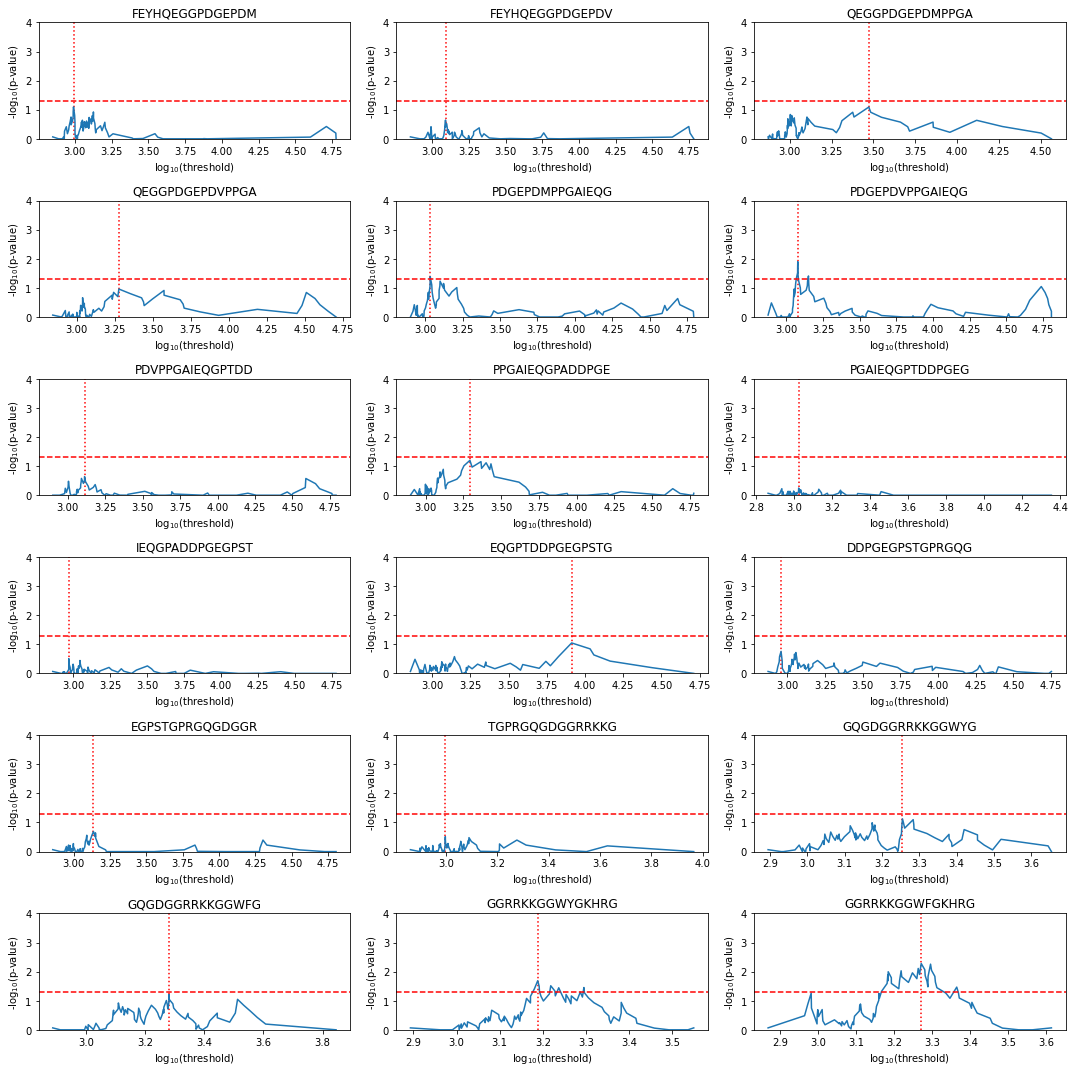

In [12]:
fig, axs = plt.subplots(6, 3, figsize = (15,15))
sequence = list(summary.sequence)
for i in range(6):
    for j in range(3):
        axs[i, j].plot(np.log10(np.array(all_lower_bounds[sequence[3*i+j]])), -np.log10(np.array(all_p_values[sequence[3*i+j]])))
        axs[i, j].set_title(sequence[3*i+j])
        axs[i, j].set_xlabel(r'log$_{10}$(threshold)')
        axs[i, j].set_ylabel(r'-log$_{10}$(p-value)')
        axs[i, j].set_ylim([0, 4])
        axs[i, j].vlines(bounds_[3*i+j], ymin = 0, ymax = 4, color = 'red', linestyles = 'dotted')
        axs[i, j].axhline(-np.log10(0.05), ls = '--', color = 'red')
fig.tight_layout()
fig.savefig("plots/infected_uninfected/"+str(1)+".png", facecolor='white', edgecolor='none', dpi=1200)
plt.show()

In [13]:
summary

,sequence,antibody,lower_bound,upper_bound,min_p_value,infected_prop,uninfected_prop,infected_prop_min,infected_prop_max,uninfected_prop_min,uninfected_prop_max
0,FEYHQEGGPDGEPDM,0415,980.000000,997.666667,0.079924,0.722222,0.894737,0.602759,0.841686,0.566331,0.854722
1,FEYHQEGGPDGEPDV,0415_,1229.666667,1230.000000,0.227018,0.592593,0.736842,0.461541,0.723645,0.421967,0.735927
2,QEGGPDGEPDMPPGA,0419,2967.333333,3046.000000,0.081105,0.203704,0.052632,0.096283,0.311124,0.060956,0.307465
3,QEGGPDGEPDVPPGA,0419_,1898.000000,2248.333333,0.109330,0.296296,0.131579,0.174507,0.418086,0.145278,0.433669
4,PDGEPDMPPGAIEQG,0423,1080.500000,1106.333333,0.041255,0.592593,0.815789,0.461541,0.723645,0.421967,0.735927
5,PDGEPDVPPGAIEQG,0423_,1197.000000,1197.333333,0.012535,0.574074,0.842105,0.442187,0.705961,0.394541,0.710722
6,PDVPPGAIEQGPTDD,0427,1291.000000,1311.000000,0.229515,0.537037,0.684211,0.404045,0.670029,0.367562,0.685070
7,PPGAIEQGPADDPGE,0430,1962.333333,2028.666667,0.063476,0.240741,0.447368,0.126710,0.354771,0.101668,0.372016
8,PGAIEQGPTDDPGEG,0431,1060.666667,1068.000000,0.568534,0.685185,0.605263,0.561310,0.809060,0.536419,0.832002
9,IEQGPADDPGEGPST,0434,930.333333,930.333333,0.311348,0.888889,0.789474,0.805068,0.972710,0.760944,0.975898


In [14]:
summary_infected = summary.copy()
summary_infected['type'] = 'infected'
summary_infected['prop'] = summary_infected.infected_prop
summary_infected['prop_max'] = summary_infected.infected_prop_max
summary_infected['prop_min'] = summary_infected.infected_prop_min
summary_uninfected = summary.copy()
summary_uninfected['type'] = 'uninfected'
summary_uninfected['prop'] = summary_uninfected.uninfected_prop
summary_uninfected['prop_max'] = summary_uninfected.uninfected_prop_max
summary_uninfected['prop_min'] = summary_uninfected.uninfected_prop_min 
summary_uninfected['antibody'] = summary_uninfected['antibody'] + '?'
summary_violin = pd.concat([summary_infected, summary_uninfected])

In [15]:
ants = list(summary.antibody.apply(lambda x: x[:-1] if '_' in x else x).astype(int))

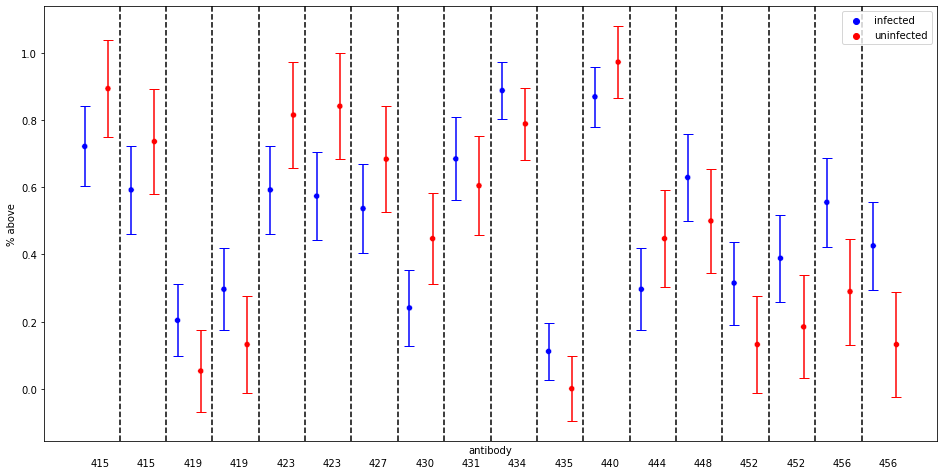

In [16]:
summary_violin = summary_violin.sort_values('antibody')
fig = plt.figure(figsize=(16, 8))
ax = sns.scatterplot(data =summary_violin, x = 'antibody', y = 'prop', hue = 'type', 
                     palette = {'infected':'blue', 'uninfected':'red'})
ax.legend(title='')
yerr = (summary_violin.prop_max - summary_violin.prop_min)/2
plt.errorbar(x=summary_violin.antibody[::2], y=summary_violin.prop[::2], yerr=yerr[::2], fmt='none', c= 'blue', capsize=5)
plt.errorbar(x=summary_violin.antibody[1::2], y=summary_violin.prop[1::2], yerr=yerr[1::2], fmt='none', c= 'red', capsize=5)
plt.ylabel('% above')
plt.xlabel('antibody')
plt.xticks([])
for i in range(18):
    if i != 17:
        ax.axvline(2*i+1.5, ls = '--', color = 'black')
    plt.text(2*i+0.25, -0.23, ants[i])
fig.savefig("plots/infected_uninfected/"+str(2)+".png", facecolor='white', edgecolor='none', dpi=1200)
plt.show()

In [17]:
summary.antibody = ants

In [18]:
summary

,sequence,antibody,lower_bound,upper_bound,min_p_value,infected_prop,uninfected_prop,infected_prop_min,infected_prop_max,uninfected_prop_min,uninfected_prop_max
0,FEYHQEGGPDGEPDM,415,980.000000,997.666667,0.079924,0.722222,0.894737,0.602759,0.841686,0.566331,0.854722
1,FEYHQEGGPDGEPDV,415,1229.666667,1230.000000,0.227018,0.592593,0.736842,0.461541,0.723645,0.421967,0.735927
2,QEGGPDGEPDMPPGA,419,2967.333333,3046.000000,0.081105,0.203704,0.052632,0.096283,0.311124,0.060956,0.307465
3,QEGGPDGEPDVPPGA,419,1898.000000,2248.333333,0.109330,0.296296,0.131579,0.174507,0.418086,0.145278,0.433669
4,PDGEPDMPPGAIEQG,423,1080.500000,1106.333333,0.041255,0.592593,0.815789,0.461541,0.723645,0.421967,0.735927
5,PDGEPDVPPGAIEQG,423,1197.000000,1197.333333,0.012535,0.574074,0.842105,0.442187,0.705961,0.394541,0.710722
6,PDVPPGAIEQGPTDD,427,1291.000000,1311.000000,0.229515,0.537037,0.684211,0.404045,0.670029,0.367562,0.685070
7,PPGAIEQGPADDPGE,430,1962.333333,2028.666667,0.063476,0.240741,0.447368,0.126710,0.354771,0.101668,0.372016
8,PGAIEQGPTDDPGEG,431,1060.666667,1068.000000,0.568534,0.685185,0.605263,0.561310,0.809060,0.536419,0.832002
9,IEQGPADDPGEGPST,434,930.333333,930.333333,0.311348,0.888889,0.789474,0.805068,0.972710,0.760944,0.975898


In [19]:
ag876 = 'FEYHQEGGPDGEPDMPPGAIEQGPADDPGEGPSTGPRGQGDGGRRKKGGWYGKHRG'
ag876_stop = [15, 19, 23, 30, 34, 40, 44, 48, 52, 56]
b958 = 'FEYHQEGGPDGEPDVPPGAIEQGPADDPGEGPSTGPRGQGDGGRRKKGGWFGKHRG'
b958_stop = [15, 19, 23, 30, 34, 40, 44, 48, 52, 56]
gd1 = 'QEGGPDGEPDVPPGAIEQGPTDDPGEGPSTGPRGQGDGGRRKKGGWFGKHRG'
gd1_stop = [15, 19, 23, 27, 31, 36, 40, 44, 48, 52]

In [20]:
adj_p_values_bonf = -np.log10(multipletests(np.array(summary['min_p_value']), method = 'bonferroni')[1])
adj_p_values_fdr = -np.log10(multipletests(np.array(summary['min_p_value']), method = 'fdr_bh')[1])

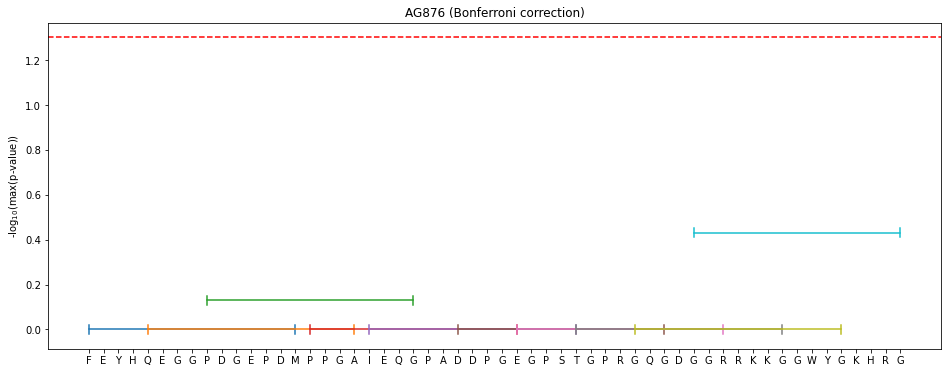

In [21]:
adj_p_values = adj_p_values_bonf[data['AG876'] == 'x']
fig = plt.figure(figsize=(16, 6))
for i in range(len(ag876_stop)):
    p = plt.plot(list(range(ag876_stop[i]-15, ag876_stop[i])), (adj_p_values[i],)*15)
    col = p[0].get_color()
    plt.plot((ag876_stop[i]-15,)*5, np.linspace(adj_p_values[i]-0.02, adj_p_values[i]+0.02, 5), col)
    plt.plot((ag876_stop[i]-1,)*5, np.linspace(adj_p_values[i]-0.02, adj_p_values[i]+0.02, 5), col)
plt.xticks(range(len(ag876)), ag876)
plt.ylabel(r'-log$_{10}$(max(p-value))')
plt.title('AG876 (Bonferroni correction)')
plt.axhline(-np.log10(0.05), ls = '--', color = 'red')
fig.savefig("plots/infected_uninfected/"+str(3)+".png", facecolor='white', edgecolor='none', dpi=1200)
plt.show()

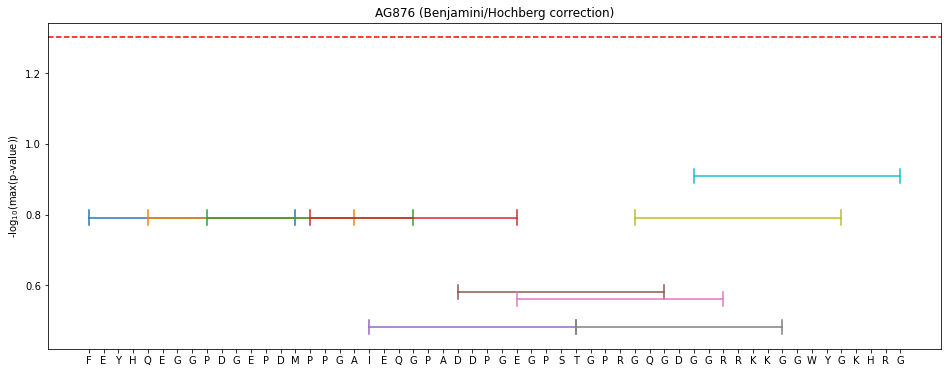

In [22]:
adj_p_values = adj_p_values_fdr[data['AG876'] == 'x']
fig = plt.figure(figsize=(16, 6))
for i in range(len(ag876_stop)):
    p = plt.plot(list(range(ag876_stop[i]-15, ag876_stop[i])), (adj_p_values[i],)*15)
    col = p[0].get_color()
    plt.plot((ag876_stop[i]-15,)*5, np.linspace(adj_p_values[i]-0.02, adj_p_values[i]+0.02, 5), col)
    plt.plot((ag876_stop[i]-1,)*5, np.linspace(adj_p_values[i]-0.02, adj_p_values[i]+0.02, 5), col)
plt.xticks(range(len(ag876)), ag876)
plt.ylabel(r'-log$_{10}$(max(p-value))')
plt.title('AG876 (Benjamini/Hochberg correction)')
plt.axhline(-np.log10(0.05), ls = '--', color = 'red')
fig.savefig("plots/infected_uninfected/"+str(4)+".png", facecolor='white', edgecolor='none', dpi=1200)
plt.show()

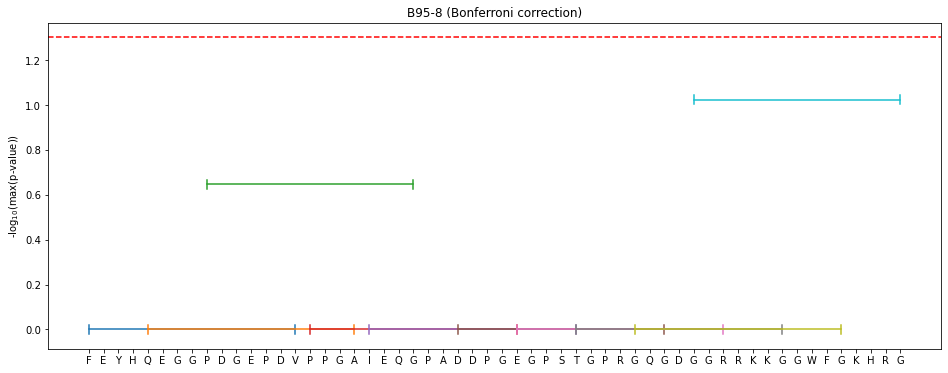

In [23]:
adj_p_values = adj_p_values = adj_p_values_bonf[data['B95-8'] == 'x']
fig = plt.figure(figsize=(16, 6))
for i in range(len(b958_stop)):
    p = plt.plot(list(range(b958_stop[i]-15, b958_stop[i])), (adj_p_values[i],)*15)
    col = p[0].get_color()
    plt.plot((b958_stop[i]-15,)*5, np.linspace(adj_p_values[i]-0.02, adj_p_values[i]+0.02, 5), col)
    plt.plot((b958_stop[i]-1,)*5, np.linspace(adj_p_values[i]-0.02, adj_p_values[i]+0.02, 5), col)
plt.xticks(range(len(b958)), b958)
plt.ylabel(r'-log$_{10}$(max(p-value))')
plt.title('B95-8 (Bonferroni correction)')
plt.axhline(-np.log10(0.05), ls = '--', color = 'red')
fig.savefig("plots/infected_uninfected/"+str(5)+".png", facecolor='white', edgecolor='none', dpi=1200)
plt.show()

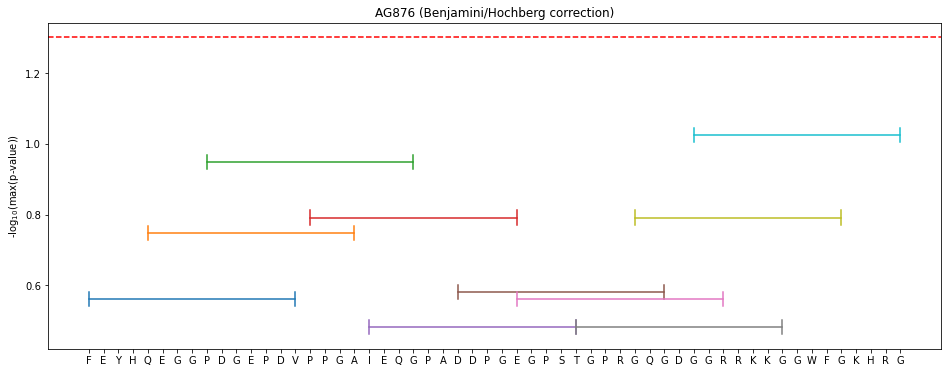

In [24]:
adj_p_values = adj_p_values = adj_p_values_fdr[data['B95-8'] == 'x']
fig = plt.figure(figsize=(16, 6))
for i in range(len(b958_stop)):
    p = plt.plot(list(range(b958_stop[i]-15, b958_stop[i])), (adj_p_values[i],)*15)
    col = p[0].get_color()
    plt.plot((b958_stop[i]-15,)*5, np.linspace(adj_p_values[i]-0.02, adj_p_values[i]+0.02, 5), col)
    plt.plot((b958_stop[i]-1,)*5, np.linspace(adj_p_values[i]-0.02, adj_p_values[i]+0.02, 5), col)
plt.xticks(range(len(b958)), b958)
plt.ylabel(r'-log$_{10}$(max(p-value))')
plt.title('AG876 (Benjamini/Hochberg correction)')
plt.axhline(-np.log10(0.05), ls = '--', color = 'red')
fig.savefig("plots/infected_uninfected/"+str(6)+".png", facecolor='white', edgecolor='none', dpi=1200)
plt.show()

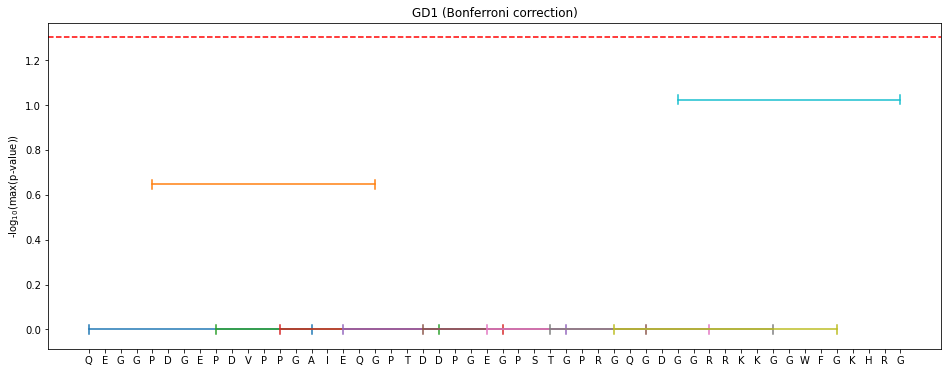

In [25]:
adj_p_values = adj_p_values = adj_p_values_bonf[data['GD1'] == 'x']
fig = plt.figure(figsize=(16, 6))
for i in range(len(gd1_stop)):
    p = plt.plot(list(range(gd1_stop[i]-15, gd1_stop[i])), (adj_p_values[i],)*15)
    col = p[0].get_color()
    plt.plot((gd1_stop[i]-15,)*5, np.linspace(adj_p_values[i]-0.02, adj_p_values[i]+0.02, 5), col)
    plt.plot((gd1_stop[i]-1,)*5, np.linspace(adj_p_values[i]-0.02, adj_p_values[i]+0.02, 5), col)
plt.xticks(range(len(gd1)), gd1)
plt.ylabel(r'-log$_{10}$(max(p-value))')
plt.title('GD1 (Bonferroni correction)')
plt.axhline(-np.log10(0.05), ls = '--', color = 'red')
fig.savefig("plots/infected_uninfected/"+str(7)+".png", facecolor='white', edgecolor='none', dpi=1200)
plt.show()

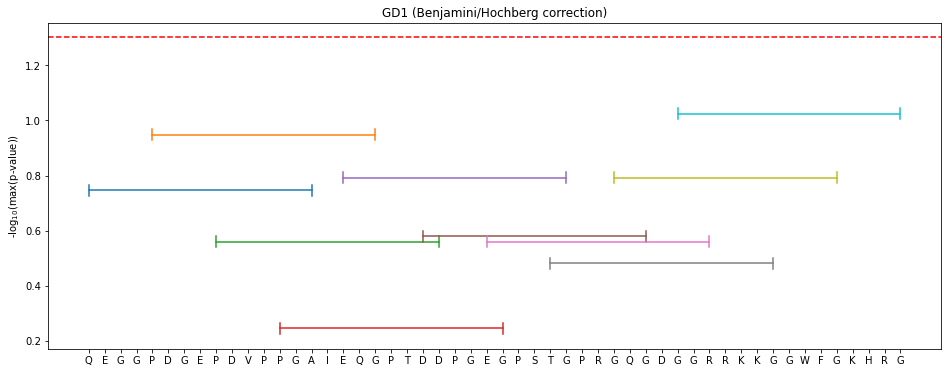

In [26]:
adj_p_values = adj_p_values = adj_p_values_fdr[data['GD1'] == 'x']
fig = plt.figure(figsize=(16, 6))
for i in range(len(gd1_stop)):
    p = plt.plot(list(range(gd1_stop[i]-15, gd1_stop[i])), (adj_p_values[i],)*15)
    col = p[0].get_color()
    plt.plot((gd1_stop[i]-15,)*5, np.linspace(adj_p_values[i]-0.02, adj_p_values[i]+0.02, 5), col)
    plt.plot((gd1_stop[i]-1,)*5, np.linspace(adj_p_values[i]-0.02, adj_p_values[i]+0.02, 5), col)
plt.xticks(range(len(gd1)), gd1)
plt.ylabel(r'-log$_{10}$(max(p-value))')
plt.title('GD1 (Benjamini/Hochberg correction)')
plt.axhline(-np.log10(0.05), ls = '--', color = 'red')
fig.savefig("plots/infected_uninfected/"+str(8)+".png", facecolor='white', edgecolor='none', dpi=1200)
plt.show()